In [1]:
%matplotlib inline

import numpy as np, pandas as pd, requests, matplotlib.pyplot as plt, mpl_toolkits.mplot3d.axes3d as axes3d, matplotlib as mpl
from bs4 import BeautifulSoup as bs
mpl.rcParams['font.family'] = 'Consolas'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

In [2]:
nullstats = pd.read_csv("pulsarstats.csv",usecols=[i+1 for i in range(6)])
nullstats["NF"] = [(entry.split("±")[0] if "±" in entry else entry.split("≤")[1] if "≤" in entry else entry.split("≥")[1] if "≥" in entry else entry) for entry in nullstats["NF (%)"]]
nullstats["NF"] = nullstats["NF"].astype(float)
nullstats["NF_e"] = [((entry.split("±")[1],entry.split("±")[1]) if "±" in entry else (entry.split("≤")[1],0) if "≤" in entry else (0,100-float(entry.split("≥")[1])) if "≥" in entry else (0,0)) for entry in nullstats["NF (%)"]]
nullstats["NF_e"] = [[float(negative),float(positive)] for (negative,positive) in nullstats["NF_e"]]
nullstats.drop(["NF (%)"],axis=1,inplace=True)

In [3]:
page = requests.get("https://www.atnf.csiro.au/people/pulsar/psrcat/proc_form.php?version=1.63&Name=Name&JName=JName&P0=P0&P1=P1&Type=Type&Age=Age&Bsurf=Bsurf&Edot=Edot&startUserDefined=true&c1_val=&c2_val=&c3_val=&c4_val=&sort_attr=jname&sort_order=asc&condition=&pulsar_names=&ephemeris=short&coords_unit=raj%2Fdecj&radius=&coords_1=&coords_2=&style=Long+with+last+digit+error&no_value=*&fsize=3&x_axis=&x_scale=linear&y_axis=&y_scale=linear&state=query&table_bottom.x=57&table_bottom.y=26").content
lines = bs(page).find('pre').get_text().split('\n')
data = [pulsar for pulsar in [line.split() for line in lines] if len(pulsar) > 1]

for pulsar in data[2:]:
    for i in [12,10,9,7,6,4,2]:
        del pulsar[i]

data[1] = [None,None]+data[1]

ATNF = pd.DataFrame(data[2:], columns=data[0])
numeric_cols=['#', 'P0', 'P1', 'AGE', 'BSURF', 'EDOT']
ATNF[numeric_cols] = ATNF[numeric_cols].apply(pd.to_numeric, errors='coerce')
ATNF = ATNF.set_index('#').rename(columns={"PSR": "TYPE"}).dropna(subset=["P0","P1"])
ATNF.index.name = None

In [4]:
merged = pd.merge(ATNF,nullstats,left_on="PSRJ",right_on="J-Name").drop(["PSR name","J-Name","P (s)","B (G)"],axis=1)

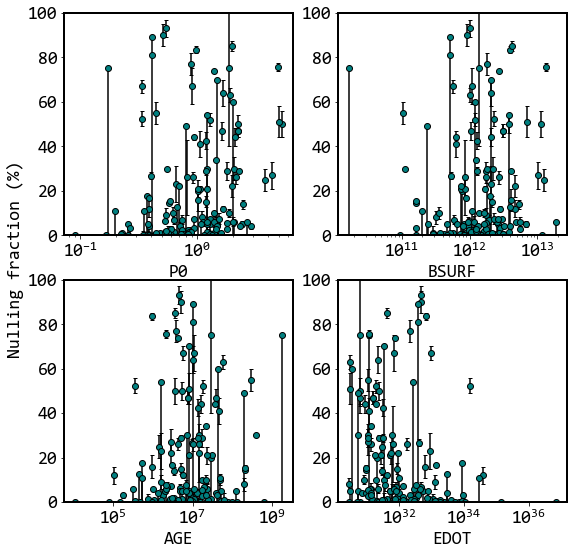

In [8]:
fig = plt.figure(figsize=(9,9))

axes = [fig.add_subplot(arrangement) for arrangement in [221,222,223,224]]
xvars = ["P0","BSURF","AGE","EDOT"]

NF_errors = np.array(list(merged["NF_e"])).T


for ax,xvar in zip(axes,xvars):
    ax.errorbar(merged[xvar],merged["NF"],yerr=NF_errors,fmt="o",ecolor="k",capsize=2,mfc="teal",mec="k")
    ax.set_xscale("log")
    ax.set_xlabel(xvar)

    ax.set_ylim((0,100))

fig.text(0.05,0.5, "Nulling fraction (%)", ha="center", va="center", rotation=90)

plt.show()

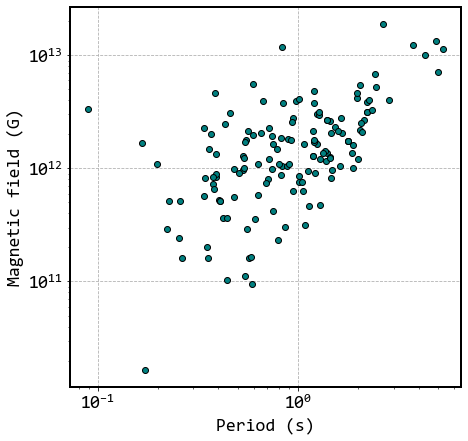

In [6]:
fig, ax = plt.subplots(figsize=(7,7))

plt.loglog(merged.P0,merged.BSURF,"o",mfc="teal",mec="k")
plt.xlabel("Period (s)")
plt.ylabel("Magnetic field (G)")
plt.grid(linestyle="--")

plt.show()

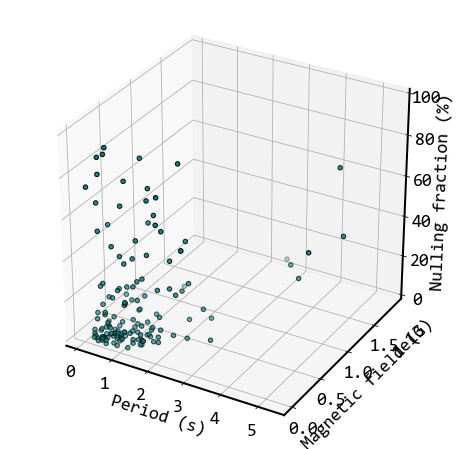

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(merged.P0,merged.BSURF,merged.NF,color="teal",edgecolor="black")
ax.set_xlabel("Period (s)")
ax.set_ylabel("Magnetic field (G)")
ax.set_zlabel("Nulling fraction (%)")

ax.set_zlim3d(0, 100)

plt.show()